## Credit One Customers' Credit Limit Setting and Default Reduction

### Import libraries

In [1]:
# import the following libraries.  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from math import sqrt
from scipy import stats # To interpret output
#import statsmodels.api as sm

In [2]:
# Leverage the built in preprocessing machine learning Models in the libraries
# 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [3]:
# Leverage the built in machine learning Models in the libraries
# import different estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier #GB builds an additive model in a forward stage-wise

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz # Export decision tree in DOT format

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score # Import cross_val_score function

from sklearn.decomposition import PCA

In [4]:
#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
#cross validation
from sklearn.model_selection import train_test_split # Split arrays/matrices into random train and test subsets

### import Credit One data

In [6]:
# We can use the new 'pd' reference and run the read_csv function from within Pandas to import our data as follows:
credit = pd.read_csv('default of credit card clients.csv', header =1)

# Note that the first row of the data file is excluded.

In [7]:
# remove redundant columns
credit=credit.drop(['ID'], axis=1)

### Dealing with non-numeric data (One-Hot Encoding)

We can see we have three variables that are listed as being the object data type; we need to covert these to 'Dummy variables' so they can be used in this multiple regression problem.

In [8]:
# Use the get_dummies() function within pandas to convert non-numeric columns to a series of binary numeric 'Dummy' columns
credit = pd.get_dummies(credit)

In [9]:
# rename to reduce the number of field name characters
credit.rename({'SEX_male':'male','SEX_female':'female','default payment next month_default': 'default','default payment next month_not default': 'not_default', 'EDUCATION_high school': 'ED_hs', 'EDUCATION_graduate school': 'ED_gs','EDUCATION_other': 'ED_o', 'EDUCATION_university': 'ED_u'}, axis=1, inplace=True)

### Create New variables

In [10]:
# Create a variable TOTAL_BILL as the sum of all the 6 months' BILL_AMTs
credit["TOTAL_BILL"] = credit["BILL_AMT1"]+credit["BILL_AMT2"]+credit["BILL_AMT3"]+credit["BILL_AMT4"]+credit["BILL_AMT5"]+credit["BILL_AMT6"]

In [11]:
# Create a variable AVE_BILL as the average of all the 6 months' BILL_AMTs
credit["AVE_BILL"] =credit["TOTAL_BILL"]/6

In [12]:
# Create a variable TOTAL_PAY as the sum of all the 6 months' PAY_AMTs
credit["TOTAL_PAY"] = credit["PAY_AMT1"]+credit["PAY_AMT2"]+credit["PAY_AMT3"]+credit["PAY_AMT4"]+credit["PAY_AMT5"]+credit["PAY_AMT6"]

In [13]:
# Create a variable AVE_PAY_AMT as the average of all the 6 months' PAY_AMTs
credit["AVE_PAY_AMT"] =credit["TOTAL_PAY"]/6

In [14]:
# shift pay features for -2 to -1                                
credit['PAY_0']=credit['PAY_0'].replace(-2,-1)
credit['PAY_2']=credit['PAY_2'].replace(-2,-1)
credit['PAY_3']=credit['PAY_3'].replace(-2,-1)
credit['PAY_4']=credit['PAY_4'].replace(-2,-1)
credit['PAY_5']=credit['PAY_5'].replace(-2,-1)
credit['PAY_6']=credit['PAY_6'].replace(-2,-1)

In [15]:
# Create another variable PAY_STATUS : first assign all non positive of PAY_x as 0, and then sum them up
credit['PAY_0']=credit['PAY_0'].replace(-1,0)
credit['PAY_2']=credit['PAY_2'].replace(-1,0)
credit['PAY_3']=credit['PAY_3'].replace(-1,0)
credit['PAY_4']=credit['PAY_4'].replace(-1,0)
credit['PAY_5']=credit['PAY_5'].replace(-1,0)
credit['PAY_6']=credit['PAY_6'].replace(-1,0)

credit["PAY_STATUS"] = credit["PAY_0"]+credit["PAY_2"]+credit["PAY_3"]+credit["PAY_4"]+credit["PAY_5"]+credit["PAY_6"]

In [16]:
# remove redundant columns
credit=credit.drop(['TOTAL_BILL','TOTAL_PAY'], axis=1)

In [17]:
# Replaced EDU from 4 columns to 1 column, as time in education.
# Create EDU as 1 to 4: 4-graduate school(longest time in school), 3-university, 2-high school, 1-others.
credit['EDU'] = credit['ED_o']
credit.loc[credit['ED_gs'] == 1, 'EDU'] = 4
credit.loc[credit['ED_u'] == 1, 'EDU'] = 3
credit.loc[credit['ED_hs'] == 1, 'EDU'] = 2
credit=credit.drop(['ED_gs','ED_hs','ED_o','ED_u','not_default','female'], axis=1)

## Identify key features that affect credit limits, "LIMIT_BAL"
### PreProcessing Data

In [18]:
corrMat = credit.corr()
corrMat.style.background_gradient(cmap='coolwarm').set_precision(2)

,LIMIT_BAL,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,zero_PAYMENT,PAY_pcount,male,default,AVE_BILL,AVE_PAY_AMT,PAY_STATUS,EDU
LIMIT_BAL,1.00,-0.11,0.14,-0.16,-0.19,-0.18,-0.17,-0.17,-0.17,0.29,0.28,0.28,0.29,0.30,0.29,0.20,0.18,0.21,0.20,0.22,0.22,-0.07,-0.24,-0.02,-0.15,0.30,0.35,-0.21,0.23
MARRIAGE,-0.11,1.00,-0.41,-0.01,-0.01,0.00,-0.00,-0.00,0.00,-0.02,-0.02,-0.02,-0.02,-0.03,-0.02,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.02,-0.01,0.03,-0.02,-0.02,-0.01,-0.00,0.15
AGE,0.14,-0.41,1.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.02,0.06,0.05,0.05,0.05,0.05,0.05,0.03,0.02,0.03,0.02,0.02,0.02,0.01,-0.02,0.09,0.01,0.05,0.04,-0.01,-0.18
PAY_0,-0.16,-0.01,-0.00,1.00,0.78,0.65,0.60,0.56,0.49,-0.02,-0.01,-0.01,0.00,0.01,0.01,-0.08,-0.05,-0.06,-0.06,-0.05,-0.05,0.28,0.70,0.04,0.37,-0.00,-0.10,0.83,-0.05
PAY_2,-0.19,-0.01,-0.01,0.78,1.00,0.76,0.65,0.60,0.53,-0.01,-0.00,0.00,0.01,0.02,0.02,-0.09,-0.05,-0.06,-0.05,-0.05,-0.04,0.25,0.77,0.05,0.32,0.01,-0.10,0.87,-0.06
PAY_3,-0.18,0.00,-0.01,0.65,0.76,1.00,0.75,0.64,0.56,-0.03,-0.01,-0.01,0.00,0.01,0.02,-0.04,-0.07,-0.06,-0.05,-0.05,-0.05,0.24,0.76,0.05,0.28,-0.00,-0.10,0.87,-0.05
PAY_4,-0.17,-0.00,-0.01,0.60,0.65,0.75,1.00,0.77,0.62,-0.03,-0.02,-0.00,0.01,0.02,0.02,-0.05,-0.04,-0.07,-0.05,-0.05,-0.05,0.22,0.74,0.04,0.27,-0.00,-0.09,0.87,-0.05
PAY_5,-0.17,-0.00,-0.01,0.56,0.60,0.64,0.77,1.00,0.75,-0.02,-0.01,0.00,0.02,0.03,0.04,-0.05,-0.04,-0.04,-0.07,-0.05,-0.05,0.19,0.73,0.04,0.26,0.01,-0.08,0.84,-0.04
PAY_6,-0.17,0.00,-0.02,0.49,0.53,0.56,0.62,0.75,1.00,-0.02,-0.01,0.00,0.02,0.04,0.05,-0.05,-0.04,-0.04,-0.03,-0.07,-0.05,0.17,0.68,0.03,0.24,0.01,-0.08,0.76,-0.03
BILL_AMT1,0.29,-0.02,0.06,-0.02,-0.01,-0.03,-0.03,-0.02,-0.02,1.00,0.95,0.89,0.86,0.83,0.80,0.14,0.10,0.16,0.16,0.17,0.18,-0.29,-0.03,0.03,-0.02,0.94,0.26,-0.03,-0.02


Clearly AVE_BILL is highly correlated to BILL_AMT1, BILL_AMT2,...,BILL_AMT6. (r ranges from 0.93 to 0.96)

In [ ]:
%matplotlib inline
credit1=credit=credit.drop(['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_pcount'], axis=1)
# create the scatter plot
sns.pairplot(credit1, hue='default', height=1.5)

In [19]:
# create a Python list of feature names
feature_b = ['MARRIAGE','AGE','male','AVE_BILL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X_b = credit[feature_b]
y_b = credit['LIMIT_BAL']

Best degree 2 with RMSE 104369.6594183956


Text(0.5, 0, 'Degree')

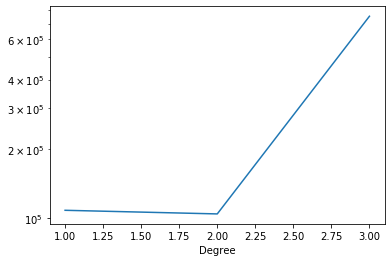

In [20]:
# copied from https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials
x_train, x_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.3)

rmses = []
degrees = np.arange(1, 4)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')

### Compare Multiple Regression Algorithms

In [21]:
# prepare each regression algorithm
algosClass = []
algosClass.append(('Random Forest Regressor',RandomForestRegressor()))
algosClass.append(('Linear Regression',LinearRegression()))
algosClass.append(('LASSO', Lasso()))
algosClass.append(('Ridge Regression', BayesianRidge()))
algosClass.append(('Support Vector Regression',SVR()))

In [23]:
# To build and assess both models recursively, we create an empty list to store the results and another to
# hold the name of each algorithm so we can easily
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X_b,y_b, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

In [24]:
# print out the results and keep them separated as follows:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.4470670944357485
Linear Regression 0.286516206846626
LASSO 0.28651612700177637
Ridge Regression 0.15541392343993676
Support Vector Regression -0.0492082139490145


Random Forest Regressor(RFR) has the highest r2. However, it is still <50%. So we will train RFR mode

In [25]:
# create a Python list of feature names
feature_b1 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X_b1 = credit[feature_b1]
y_b1 = credit['LIMIT_BAL']

In [26]:
# To build and assess both models recursively, we create an empty list to store the results and another to
# hold the name of each algorithm so we can easily
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X_b1,y_b1, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

In [27]:
# print out the results and keep them separated as follows:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.4266963578737903
Linear Regression 0.2812970661026457
LASSO 0.2812970790740261
Ridge Regression 0.19375905815129021
Support Vector Regression -0.05064563138302436


Note that we don't lose too much by replacing PAY_AMT1,.. PAY_AMT6 by AVE_PAY_AMT. Note that Ridge Regression actually has R2 increased.

In [102]:
# drop PAY_pcount, for it is highly correlated to PAY_STATUS
feature_b2 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','EDU','default']
# use the list to select a subset of the original DataFrame
X_b2 = credit[feature_b2]
y_b2 = credit['LIMIT_BAL']

In [103]:
# To build and assess both models recursively, we create an empty list to store the results and another to
# hold the name of each algorithm so we can easily
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X_b2, y_b2, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

In [104]:
# print out the results and keep them separated as follows:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.42593249368004676
Linear Regression 0.26242750136124865
LASSO 0.2624275192320799
Ridge Regression 0.18798108670184435
Support Vector Regression -0.050624833978828


Note that we don't lose too much by ther dropping PAY_pcount. Note that R2 for RFR and SVR increase.
When we further remove zero_PAYMENT, insignificant reduction in R2.
 


#### Train the models

In [36]:
# Train/Test Split: splitting data into 80% for training and 20% for testing and ensuring the data
# is randomly stratified to prevent and bias from occurring due to any ordering of the data.
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size = .20, random_state=123)

In [37]:
# RFC = RandomForestClassifier()
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [38]:
RFR.score(X_test,y_test)

0.45772085818056774

In [39]:
y_pred_rfr = RFR.predict(X_test)

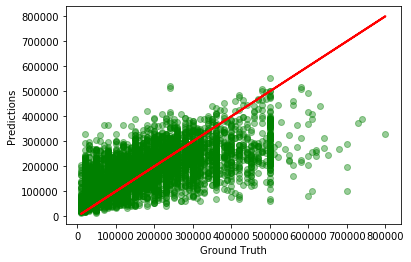

In [40]:
plt.scatter(y_test, y_pred_rfr,  color='green', alpha = 0.4)
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

In [41]:
# compare actual response values (y_test) with predicted response values (y_pred)
mae = mean_absolute_error(y_test, y_pred_rfr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r_square = r2_score(y_test, y_pred_rfr, multioutput='variance_weighted')
print('Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Mean Absolute Error: 68666.729 , Root Mean Squared Error: 94462.261 , R-squared: 0.458


### Run Linear regression in scikit-learn

In [42]:
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)
# make predictions on the testing set
y_pred_lm = linreg.predict(X_test)

In [43]:
# compare actual response values (y_test) with predicted response values (y_pred)
mae = mean_absolute_error(y_test, y_pred_lm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lm))
r_square = r2_score(y_test, y_pred_lm, multioutput='variance_weighted')
print('Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Mean Absolute Error: 83385.099 , Root Mean Squared Error: 107967.848 , R-squared: 0.292


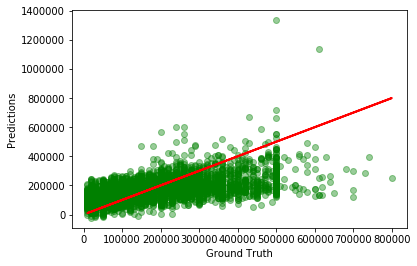

In [44]:
plt.scatter(y_test, y_pred_lm,  color='green', alpha = 0.4)
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

#### Principal Component Analysis (PCA)

PCA identifies highly correlated features and remove the redundant data for prediction, thus reduces dimensions

In [46]:
pca = PCA(n_components=5)  # n_components specifies the new dimensionality
X_reduced = pca.fit(X_b).transform(X_b) # or just pca.fit_transform(X)
X_reduced = pd.DataFrame(data=X_reduced, columns=['x1','x2','x3','x4','x5'])

In [47]:
#print('Components:', pca.components_)
print('Explained Variance:', pca.explained_variance_)
print('Explained Variance Ratio:', pca.explained_variance_ratio_ )

Explained Variance: [4.08863089e+09 6.15852003e+08 3.21890702e+08 2.61932362e+08
 2.12791961e+08]
Explained Variance Ratio: [0.69157654 0.10416905 0.0544466  0.04430487 0.03599296]


PCA X1 explains 69.2% of the variation, and X2 explains 10.4%. Together is 79.6%

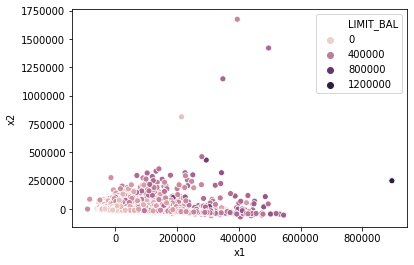

In [49]:
sns.scatterplot(x='x1', y='x2', hue=y_b ,data=X_reduced)

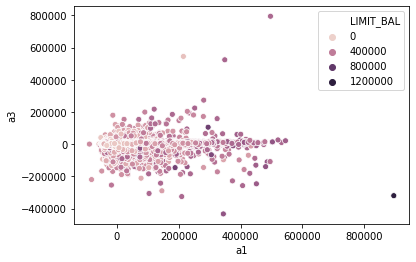

In [51]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=5, batch_size=10) # batch_size specifies the number of samples per batch
X_reduced = pca.fit(X_b).transform(X_b) # or just pca.fit_transform(X)
X_reduced = pd.DataFrame(data=X_reduced, columns=['a1','a2','a3','a4','a5'])
sns.scatterplot(x='a1', y='a3', hue=y_b ,data=X_reduced)

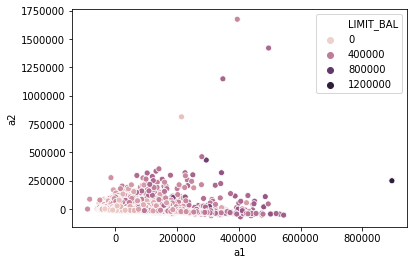

In [52]:
sns.scatterplot(x='a1', y='a2', hue=y_b ,data=X_reduced)

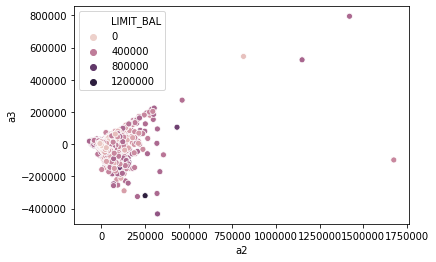

In [53]:
sns.scatterplot(x='a2', y='a3', hue=y_b ,data=X_reduced)

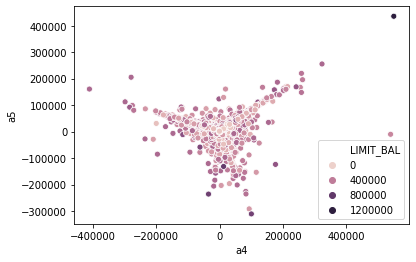

In [54]:
sns.scatterplot(x='a4', y='a5', hue=y_b ,data=X_reduced)

#### Check if the reduced columns also reduce RMSE or MAE

In [55]:
# Train/Test Split: splitting data into 80% for training and 20% for testing and ensuring the data
# is randomly stratified to prevent and bias from occurring due to any ordering of the data.
X_train, X_test, y_train, y_test = train_test_split(X_b2, y_b2, test_size = .20, random_state=123)

In [56]:
# RFC = RandomForestClassifier()
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
RFR.score(X_test,y_test)

0.42807587345251347

In [58]:
y_pred_rfr = RFR.predict(X_test)

In [59]:
# compare actual response values (y_test) with predicted response values (y_pred)
mae = mean_absolute_error(y_test, y_pred_rfr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r_square = r2_score(y_test, y_pred_rfr, multioutput='variance_weighted')
print('Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Mean Absolute Error: 70204.922 , Root Mean Squared Error: 97009.909 , R-squared: 0.428


removing PAY_AMTx and PAY_pcount increase errors and reduce R2

In [60]:
# Train/Test Split: splitting data into 80% for training and 20% for testing and ensuring the data
# is randomly stratified to prevent and bias from occurring due to any ordering of the data.
X_train, X_test, y_train, y_test = train_test_split(X_b1, y_b1, test_size = .20, random_state=123)

In [61]:
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [62]:
RFR.score(X_test,y_test)

0.4228499255931313

In [63]:
y_pred_rfr = RFR.predict(X_test)
# compare actual response values (y_test) with predicted response values (y_pred)
mae = mean_absolute_error(y_test, y_pred_rfr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r_square = r2_score(y_test, y_pred_rfr, multioutput='variance_weighted')
print('Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Mean Absolute Error: 70559.577 , Root Mean Squared Error: 97452.114 , R-squared: 0.423


In [105]:
# Train/Test Split: splitting data into 80% for training and 20% for testing and ensuring the data
# is randomly stratified to prevent and bias from occurring due to any ordering of the data.
X_train, X_test, y_train, y_test = train_test_split(X_b2, y_b2, test_size = .20, random_state=123)

In [106]:
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [107]:
RFR.score(X_test,y_test)

0.4251831022656505

In [108]:
y_pred_rfr = RFR.predict(X_test)
# compare actual response values (y_test) with predicted response values (y_pred)
mae = mean_absolute_error(y_test, y_pred_rfr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r_square = r2_score(y_test, y_pred_rfr, multioutput='variance_weighted')
print('Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Mean Absolute Error: 70580.243 , Root Mean Squared Error: 97254.935 , R-squared: 0.425


#### Transform LIMIT_BAL from continuous values into categorical variables , LIMIT_BAL_GP,LIMIT_BAL_GPx


In [64]:
# Convert LIMIT_BAL from Continuous variable to categorical data
# Create LIMI_BAL_GP
# Use floor_divide by 100000 to get the tens, then multiply by 100000. 
# Create 5 groups
credit['LIMIT_BAL_GP'] = np.floor_divide(credit['LIMIT_BAL'],100000)
credit.loc[credit['LIMIT_BAL_GP'] == 0, 'LIMIT_BAL_GP'] = "<100000"
credit.loc[credit['LIMIT_BAL_GP'] == 1, 'LIMIT_BAL_GP'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP'] == 2, 'LIMIT_BAL_GP'] = "<300000"
credit.loc[credit['LIMIT_BAL_GP'] == 3, 'LIMIT_BAL_GP'] = "<400000"
credit.loc[credit['LIMIT_BAL_GP'] == 4, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 5, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 6, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 7, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 8, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 9, 'LIMIT_BAL_GP'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP'] == 10, 'LIMIT_BAL_GP'] = ">=400000"
# Create LIMI_BAL_GP

In [66]:
# Use the grouped LIMIT_BAL
y = credit.LIMIT_BAL_GP

In [67]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_b, y, cv=10, scoring='accuracy')
print(scores)

[0.49466667 0.493      0.50166667 0.48433333 0.51133333 0.51566667
 0.499      0.49066667 0.51166667 0.506     ]


In [68]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.5008


In [69]:
feature2 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X2 = credit[feature2]
y2 = credit['LIMIT_BAL_GP']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=123)

In [70]:
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X2, y2, cv=10, scoring='accuracy')
print(scores)

[0.493      0.49066667 0.50533333 0.48533333 0.50733333 0.518
 0.496      0.50133333 0.498      0.50666667]


In [72]:
# search for an optimal value of K for KNN
k_range = list(range(5, 22))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_b, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.5008, 0.5027333333333333, 0.5045666666666667, 0.5077333333333334, 0.5115666666666667, 0.5128, 0.5125333333333334, 0.5154666666666666, 0.516, 0.5179666666666667, 0.5177666666666666, 0.5184666666666666, 0.5181, 0.5192, 0.5195000000000001, 0.5212, 0.5196999999999999]


Text(0, 0.5, 'Cross-Validated Accuracy')

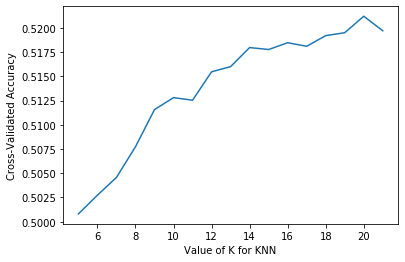

In [73]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

k=20 has the highest accuracy of ~0.52

In [74]:
# define the parameter values that should be searched
k_range = list(range(16, 22))
weight_options = ['uniform', 'distance']

In [75]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [16, 17, 18, 19, 20, 21], 'weights': ['uniform', 'distance']}


In [76]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X2, y2)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=21, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [16, 17, 18, 19, 20, 21],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [77]:
# view the results as a pandas DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.513300,0.008935,"{'n_neighbors': 16, 'weights': 'uniform'}"
1,0.502100,0.011437,"{'n_neighbors': 16, 'weights': 'distance'}"
2,0.515033,0.008739,"{'n_neighbors': 17, 'weights': 'uniform'}"
3,0.503633,0.011000,"{'n_neighbors': 17, 'weights': 'distance'}"
4,0.515167,0.008710,"{'n_neighbors': 18, 'weights': 'uniform'}"
5,0.503667,0.011928,"{'n_neighbors': 18, 'weights': 'distance'}"
6,0.515200,0.009542,"{'n_neighbors': 19, 'weights': 'uniform'}"
7,0.505533,0.011031,"{'n_neighbors': 19, 'weights': 'distance'}"
8,0.516567,0.009838,"{'n_neighbors': 20, 'weights': 'uniform'}"
9,0.506767,0.011057,"{'n_neighbors': 20, 'weights': 'distance'}"


In [78]:
# create LIMI_BAL_GP1
# Use floor_divide by 100000 to get the tens, then multiply by 100000. 
credit['LIMIT_BAL_GP1'] = np.floor_divide(credit['LIMIT_BAL'],100000)
credit.loc[credit['LIMIT_BAL_GP1'] == 0, 'LIMIT_BAL_GP1'] = "<100000"
credit.loc[credit['LIMIT_BAL_GP1'] == 1, 'LIMIT_BAL_GP1'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP1'] == 2, 'LIMIT_BAL_GP1'] = "<300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 3, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 4, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 5, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 6, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 7, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 8, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 9, 'LIMIT_BAL_GP1'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP1'] == 10, 'LIMIT_BAL_GP1'] = ">=300000"

In [79]:
feature3 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X3 = credit[feature3]
y3 = credit['LIMIT_BAL_GP1']

In [80]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X3, y3, cv=10, scoring='accuracy')
print(scores)

[0.496      0.49733333 0.50766667 0.50666667 0.51233333 0.53133333
 0.514      0.50366667 0.50466667 0.51333333]


In [81]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.5087000000000002


LIMI_BAL_GP1 grouping is not very good

In [82]:
# create LIMI_BAL_GP2
# Use floor_divide by 100000 to get the tens, then multiply by 100000. 
credit['LIMIT_BAL_GP2'] = np.floor_divide(credit['LIMIT_BAL'],100000)
credit.loc[credit['LIMIT_BAL_GP2'] == 0, 'LIMIT_BAL_GP2'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP2'] == 1, 'LIMIT_BAL_GP2'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP2'] == 2, 'LIMIT_BAL_GP2'] = "<400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 3, 'LIMIT_BAL_GP2'] = "<400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 4, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 5, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 6, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 7, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 8, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 9, 'LIMIT_BAL_GP2'] = ">=400000"
credit.loc[credit['LIMIT_BAL_GP2'] == 10, 'LIMIT_BAL_GP2'] = ">=400000"

In [83]:
feature4 = ['MARRIAGE','AGE','male','AVE_BILL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X4 = credit[feature4]
y4 = credit['LIMIT_BAL_GP2']

In [84]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X4, y4, cv=10, scoring='accuracy')
print(scores)

[0.692      0.686      0.69       0.694      0.69233333 0.69666667
 0.69233333 0.67966667 0.69       0.698     ]


In [85]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6910999999999999


In [86]:
# search for an optimal value of K for KNN
k_range = list(range(10, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X4, y4, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.6910999999999999, 0.6903666666666667, 0.6925333333333333, 0.6926, 0.6937666666666666, 0.6926333333333333, 0.6936666666666667, 0.6937333333333333, 0.6936, 0.6935333333333333, 0.6942666666666667, 0.6923666666666667, 0.6938, 0.6925666666666667, 0.6946999999999999, 0.6940333333333333, 0.6939666666666666, 0.6949, 0.6942666666666667, 0.6945666666666666, 0.6941333333333335]


Text(0, 0.5, 'Cross-Validated Accuracy')

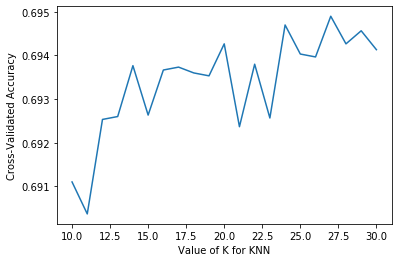

In [87]:
#plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

accuracy increases to 0.695 when k =27

In [88]:
feature5 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU','default']
# use the list to select a subset of the original DataFrame
X5 = credit[feature5]
y5 = credit['LIMIT_BAL_GP2']

In [89]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X5, y5, cv=10, scoring='accuracy')
print(scores)

[0.686      0.68466667 0.69033333 0.682      0.691      0.69633333
 0.67966667 0.66633333 0.677      0.692     ]


In [90]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6845333333333334


Note that if I replaced PAY_AMT1,,,, PAY_AMT6 by AVE_PAY_AMT, not much accuracy lose, accuracy is 0.685

In [91]:
feature6 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','EDU','default']
# use the list to select a subset of the original DataFrame
X6 = credit[feature6]
y6 = credit['LIMIT_BAL_GP2']

In [92]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X6, y6, cv=10, scoring='accuracy')
print(scores)

[0.68733333 0.68466667 0.69133333 0.68133333 0.69033333 0.695
 0.68066667 0.665      0.67733333 0.692     ]


In [93]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6845


Remove PAY_pcount and zero_PAYMENT, accuracy is about the same.

In [95]:
# create LIMI_BAL_GP3
# Use floor_divide by 100000 to get the tens, then multiply by 100000. 
credit['LIMIT_BAL_GP3'] = np.floor_divide(credit['LIMIT_BAL'],100000)
credit.loc[credit['LIMIT_BAL_GP3'] == 0, 'LIMIT_BAL_GP3'] = "<100000"
credit.loc[credit['LIMIT_BAL_GP3'] == 1, 'LIMIT_BAL_GP3'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP3'] == 2, 'LIMIT_BAL_GP3'] = "<200000"
credit.loc[credit['LIMIT_BAL_GP3'] == 3, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 4, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 5, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 6, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 7, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 8, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 9, 'LIMIT_BAL_GP3'] = ">=300000"
credit.loc[credit['LIMIT_BAL_GP3'] == 10, 'LIMIT_BAL_GP3'] = ">=300000"

In [96]:
feature6 = ['MARRIAGE','AGE','male','AVE_BILL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','PAY_STATUS','EDU','default']
# use the list to select a subset of the original DataFrame
X6 = credit[feature6]
y6 = credit['LIMIT_BAL_GP3']

In [97]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X6, y6, cv=10, scoring='accuracy')
print(scores)

[0.641      0.64266667 0.63666667 0.641      0.657      0.65633333
 0.645      0.62633333 0.65333333 0.64133333]


In [98]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6440666666666667


In [99]:
feature7 = ['MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','EDU','default']
# use the list to select a subset of the original DataFrame
X7 = credit[feature7]
y7 = credit['LIMIT_BAL_GP3']

In [100]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X7, y7, cv=10, scoring='accuracy')
print(scores)

[0.63466667 0.63733333 0.63366667 0.62733333 0.64766667 0.64666667
 0.636      0.61966667 0.64466667 0.63533333]


In [101]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6363000000000001


# Identify key features that affect "Default"

### Logistic regression

In [109]:
feature_col =  ['LIMIT_BAL','MARRIAGE','AGE','male','AVE_BILL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','PAY_STATUS','zero_PAYMENT','EDU']
X = credit[feature_col]
y = credit['default']

In [110]:
# Standardizing the features
X_1 = StandardScaler().fit_transform(X)

C:\Users\cthian972\anaconda3\envs\hw\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best degree 2 with RMSE 0.4381780460041329


C:\Users\cthian972\anaconda3\envs\hw\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 0, 'Degree')

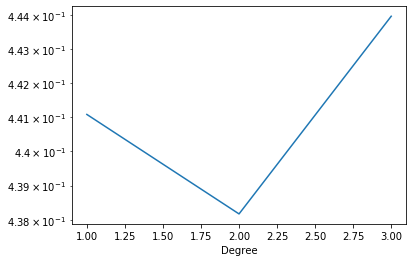

In [111]:
# applied to the StandardizedtScaler X
x_train, x_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3)

rmses = []
degrees = np.arange(1, 4)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Logistic regression
    poly_reg = LogisticRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')

#### Compare Classifiers

In [112]:
algos_Class = [] # empty list
algos_Class.append(('Random Forest Classifier = ', RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier = ', DecisionTreeClassifier()))
algos_Class.append(('Gradient Boosting Classifier = ', GradientBoostingClassifier()))
algos_Class.append(('Logistic Regression = ', LogisticRegression()))

In [113]:
# classification
results = []
names = []
for name, model in algos_Class:
    accuracy = cross_val_score(model, X, y, cv = 3, scoring ='accuracy')
    names.append(name)
    results.append(accuracy)

C:\Users\cthian972\anaconda3\envs\hw\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [114]:
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier =  0.8052
Decision Tree Classifier =  0.7167333333333333
Gradient Boosting Classifier =  0.8059
Logistic Regression =  0.7788


In [115]:
# classification
results = []
names = []
for name, model in algos_Class:
    accuracy = cross_val_score(model, X_1, y, cv = 3, scoring ='accuracy')
    names.append(name)
    results.append(accuracy)

In [116]:
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier =  0.8060666666666666
Decision Tree Classifier =  0.7181333333333333
Gradient Boosting Classifier =  0.8058666666666667
Logistic Regression =  0.8029999999999999


In [117]:
# Split X and y into 75% training and 25% testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25, random_state= 12)

In [118]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# train the model on the training set
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

#### Evaluate model

In [120]:
# compare actual response values (y_test) with predicted response values (y_pred)
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_square = r2_score(y_test, y_pred, multioutput='variance_weighted')
print('Accuracy: %.3f'% accuracy,', Mean Absolute Error: %5.3f'% mae,', Root Mean Squared Error: %6.3f'%rmse, ', R-squared: %.3f'% r_square)

Accuracy: 0.804 , Mean Absolute Error: 43.444 , Root Mean Squared Error:  0.443 , R-squared: -0.129


In [121]:
# Metrics from Confusion matrix 
confusion = confusion_matrix(y_test, y_pred)
TruePositive = confusion[1, 1]
TrueNegative = confusion[0, 0]
FalsePositive = confusion[0, 1]
FalseNegative = confusion[1, 0]

# Classification Accuracy: how often is the classifier correct?
Accuracy = (TruePositive + TrueNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# Misclassification Rate or classification error: how often is the classifier incorrect
Misclassification = (FalsePositive + FalseNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# How often is the prediction correct when the actual value is positive?
Sensitivity =  TruePositive  / float(TruePositive + FalseNegative)

# How often is the prediction correct when the actual value is negative?
Specificity = TrueNegative / float(TrueNegative + FalsePositive)

# How often is the prediction incorrect when the actual value is negative?
FalsePositiveRate = FalsePositive / float(FalsePositive + TrueNegative)

# When a positive value is predicted, how often is the prediction correct?
Precision = TruePositive / float(TruePositive + FalsePositive)

print('TruePositive  : %d' %TruePositive , 'FalsePositive : %d'% FalsePositive)
print('FalseNegative : %d' %FalseNegative, 'TrueNegative  : %d'% TrueNegative)
print('Accuracy: %.3f'% Accuracy,',        Misclassification Rate: %.3f'% Misclassification)
print('Sensitivity: %.3f'% Sensitivity, ',  Specificity: %.3f'% Specificity)
print('False Positive Rate: %.3f'% FalsePositiveRate, ', Precision: %.3f'% Precision)

TruePositive  : 398 FalsePositive : 192
FalseNegative : 1277 TrueNegative  : 5633
Accuracy: 0.804 ,        Misclassification Rate: 0.196
Sensitivity: 0.238 ,  Specificity: 0.967
False Positive Rate: 0.033 , Precision: 0.675


In [122]:
print(confusion)

[[5633  192]
 [1277  398]]


In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.88      5825
           1       0.67      0.24      0.35      1675

    accuracy                           0.80      7500
   macro avg       0.74      0.60      0.62      7500
weighted avg       0.78      0.80      0.77      7500



In the classification report, for all identifed as "not default", 82% are correctly identified. (precision). For all instances that are actually "not default", 97% was classified correctly (Recall). For the "default" group, precision is "67%" and recall is 24%. Which is not too good. Since there are more count in the 'not default" group, the weighted mean precision is 78% and weighted recall is 80%.

In [124]:
X1 = RobustScaler(quantile_range=(25.0, 75.0)).fit_transform(X)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state= 123)

In [126]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# train the model on the training set
logreg.fit(X_train, y_train)
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      5873
           1       0.63      0.25      0.36      1627

    accuracy                           0.81      7500
   macro avg       0.73      0.60      0.62      7500
weighted avg       0.78      0.81      0.77      7500



for "not default", 82% are correctly identified(precision). For "not default", 96% was classified correctly(Recall). For the "default" group, precision is "63%" and recall is 25%.

In [128]:
feature_col1 =  ['LIMIT_BAL','MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU']
X2=credit[feature_col1]

In [129]:
X2 = RobustScaler(quantile_range=(25.0, 75.0)).fit_transform(X2)

In [130]:
# Split X and y into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state= 12)

In [131]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# train the model on the training set
logreg.fit(X_train, y_train)
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4648
           1       0.65      0.26      0.37      1352

    accuracy                           0.80      6000
   macro avg       0.73      0.61      0.63      6000
weighted avg       0.78      0.80      0.77      6000



Note that AVE PAY AMT can replace PAY_AMT1,..., PAY_AMT6. The performance are akmost the same. In the classification report, for all identifed as "not default", 82% are correctly identified. (precision). For all instances that are actually "not default", 96% was classified correctly (Recall). For the "default" group, precision is "65%" and recall is 26%. Which is not too good. Since there are more count in the 'not default" group, the weighted mean precision is 78% and weighted recall is close to 80%.

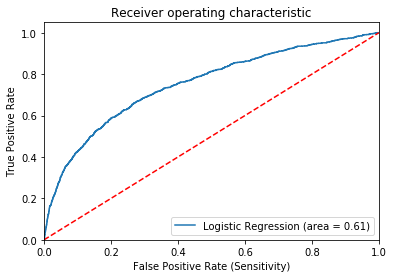

In [133]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### PCA

In [134]:
pca = PCA(n_components=4)  # n_components specifies the new dimensionality
X_log_pca = pca.fit(X2).transform(X2) # or just pca.fit_transform(X)
X_log_pca = pd.DataFrame(data=X_reduced, columns=['x1','x2','x3','x4'])

In [135]:
#print('Components:', pca.components_)
print('Explained Variance:', pca.explained_variance_)
print('Explained Variance Ratio:', pca.explained_variance_ratio_ )

Explained Variance: [6.93667299 5.09086265 1.3281837  0.67859108]
Explained Variance Ratio: [0.42702016 0.31339246 0.08176272 0.04177393]


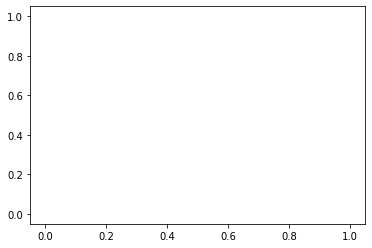

In [136]:
sns.scatterplot(x='x1', y='x2', hue=y ,data=X_log_pca)

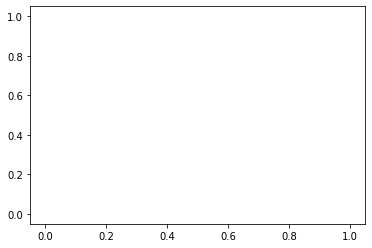

In [137]:
sns.scatterplot(x='x1', y='x3', hue=y ,data=X_log_pca)

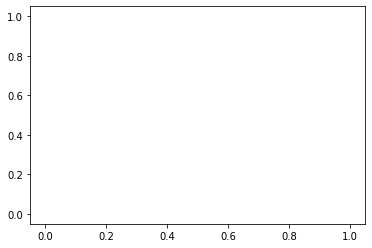

In [138]:
sns.scatterplot(x='x2', y='x3', hue=y ,data=X_log_pca)

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_log_pca, y, test_size=0.25, random_state= 12)

In [140]:
logreg = LogisticRegression()
# train the model on the training set
logreg.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

### Random Forest Classifier

In [141]:
feature_col1 =  ['LIMIT_BAL','MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU']
X2 = credit[feature_col1]
y = credit['default']

#### Train the model

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = .20, random_state = 123)
algo = RandomForestClassifier()
model = algo.fit(X_train,y_train)

In [143]:
preds = model.predict(X_test)

In [144]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4696
           1       0.56      0.34      0.42      1304

    accuracy                           0.80      6000
   macro avg       0.70      0.63      0.65      6000
weighted avg       0.77      0.80      0.78      6000



for all identifed as "not default", 84% are correctly identified(precision). For all instances that are actually "not default", 92% was classified correctly (Recall). For the "default" group , precision is 56% and recall is 34%. Since there are more count in the 'not default" group, the weighted mean precision is 77% and weighted recall is close to 80%.

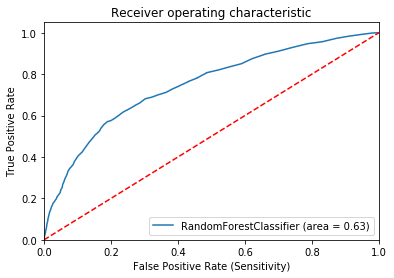

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rfr_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForestClassifier (area = %0.2f)' % rfr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [146]:
# remove LIMIT_BAL
X2a = X2.drop(['LIMIT_BAL'], axis=1)

### Gradient Boosting Classifier

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X2a, y, test_size = .20, random_state = 153)
algo = GradientBoostingClassifier()
gbc = algo.fit(X_train,y_train)
preds = gbc.predict(X_test)

In [149]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4660
           1       0.65      0.32      0.43      1340

    accuracy                           0.81      6000
   macro avg       0.74      0.63      0.66      6000
weighted avg       0.79      0.81      0.78      6000



### features with 2 way interactions

In [151]:
# code is from https://www.youtube.com/watch?v=V0u6bxQOUJ8
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
def add_interactions (Z):
    # Get feature names
    combos = list(combinations(list(Z.columns),2))
    colnames = list(Z.columns)+['_'.join(x) for x in combos]
    
    # Find imtractions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    Z = poly.fit_transform(Z)
    Z = pd.DataFrame(Z)
    Z.columns = colnames
    
    # Remove interaction terms with all 0 values
    noint_indices =[i for i, x in enumerate(list((Z == 0).all())) if x]
    Z = Z.drop(Z.columns[noint_indices],axis=1)
    
    return Z

In [168]:
feature_col1 = ['LIMIT_BAL','MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU']
X3 = credit[feature_col1]
y3 = credit['default']

In [169]:
X3 = add_interactions(X3)
print(X3.head(2))

   LIMIT_BAL  MARRIAGE   AGE  male     AVE_BILL  AVE_PAY_AMT  PAY_STATUS  \
0    20000.0       1.0  24.0   0.0  1284.000000   114.833333         4.0   
1   120000.0       2.0  26.0   0.0  2846.166667   833.333333         4.0   

   PAY_pcount  zero_PAYMENT  EDU  ...  AVE_PAY_AMT_PAY_STATUS  \
0         2.0           5.0  3.0  ...              459.333333   
1         2.0           2.0  3.0  ...             3333.333333   

   AVE_PAY_AMT_PAY_pcount  AVE_PAY_AMT_zero_PAYMENT  AVE_PAY_AMT_EDU  \
0              229.666667                574.166667            344.5   
1             1666.666667               1666.666667           2500.0   

   PAY_STATUS_PAY_pcount  PAY_STATUS_zero_PAYMENT  PAY_STATUS_EDU  \
0                    8.0                     20.0            12.0   
1                    8.0                      8.0            12.0   

   PAY_pcount_zero_PAYMENT  PAY_pcount_EDU  zero_PAYMENT_EDU  
0                     10.0             6.0              15.0  
1                      4

In [170]:
X3 = RobustScaler(quantile_range=(25.0, 75.0)).fit_transform(X3)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state= 112)

In [172]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# train the model on the training set
logreg.fit(X_train, y_train)

C:\Users\cthian972\anaconda3\envs\hw\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

In [174]:
# Metrics from Confusion matrix 
confusion = confusion_matrix(y_test, y_pred)
TruePositive = confusion[1, 1]
TrueNegative = confusion[0, 0]
FalsePositive = confusion[0, 1]
FalseNegative = confusion[1, 0]

# Classification Accuracy: how often is the classifier correct?
Accuracy = (TruePositive + TrueNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# Misclassification Rate or classification error: how often is the classifier incorrect
Misclassification = (FalsePositive + FalseNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# How often is the prediction correct when the actual value is positive?
Sensitivity =  TruePositive  / float(TruePositive + FalseNegative)

# How often is the prediction correct when the actual value is negative?
Specificity = TrueNegative / float(TrueNegative + FalsePositive)

# How often is the prediction incorrect when the actual value is negative?
FalsePositiveRate = FalsePositive / float(FalsePositive + TrueNegative)

# When a positive value is predicted, how often is the prediction correct?
Precision = TruePositive / float(TruePositive + FalsePositive)

print('TruePositive  : %d' %TruePositive , 'FalsePositive : %d'% FalsePositive)
print('FalseNegative : %d' %FalseNegative, 'TrueNegative  : %d'% TrueNegative)
print('Accuracy: %.3f'% Accuracy,',        Misclassification Rate: %.3f'% Misclassification)
print('Sensitivity: %.3f'% Sensitivity, ',  Specificity: %.3f'% Specificity)
print('False Positive Rate: %.3f'% FalsePositiveRate, ', Precision: %.3f'% Precision)

TruePositive  : 416 FalsePositive : 258
FalseNegative : 880 TrueNegative  : 4446
Accuracy: 0.810 ,        Misclassification Rate: 0.190
Sensitivity: 0.321 ,  Specificity: 0.945
False Positive Rate: 0.055 , Precision: 0.617


ADding 2 way interaction, did not improve Sensitivity much.

Note that when I remove the 'LIMIT_BAL' term the result is still the same

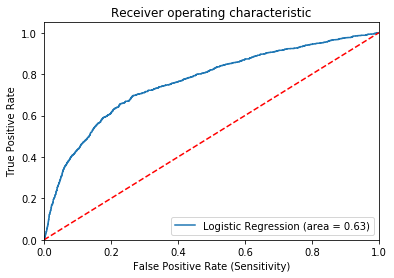

In [159]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

A model with high discrimination ability will have high sensitivity (True Positive Rate) and specificity (False Positive Rate) simultaneously, leading to an ROC curve which goes close to the top left corner of the plot. A model with no discrimination ability will have an ROC curve which is the 45 degree diagonal line. In this case, we can see that this model is "so so"

In [ ]:
from sklearn.pipeline import Pipeline
# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe = Pipeline([('pca', PCA()),
                 ('tree', DecisionTreeClassifier())])

pipe.fit(X_train,y_train)

pipe.predict(X_test)

Adding PAY_AMT1 to PAY_AMT6, and 2 way interaction and see if there is any improvement over Sensitivity

In [160]:
feature_col2 = ['LIMIT_BAL','MARRIAGE','AGE','male','AVE_BILL','AVE_PAY_AMT','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','PAY_STATUS','PAY_pcount','zero_PAYMENT','EDU']
X4 = credit[feature_col2]
y4 = credit['default']

In [161]:
X4 = add_interactions(X4)

In [162]:
X4 = RobustScaler(quantile_range=(25.0, 75.0)).fit_transform(X4)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.2, random_state= 112)

In [164]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# train the model on the training set
logreg.fit(X_train, y_train)
# make predictions on the testing set and store the predicted response values
y_pred = logreg.predict(X_test)

C:\Users\cthian972\anaconda3\envs\hw\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [165]:
# Metrics from Confusion matrix 
confusion = confusion_matrix(y_test, y_pred)
TruePositive = confusion[1, 1]
TrueNegative = confusion[0, 0]
FalsePositive = confusion[0, 1]
FalseNegative = confusion[1, 0]

# Classification Accuracy: how often is the classifier correct?
Accuracy = (TruePositive + TrueNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# Misclassification Rate or classification error: how often is the classifier incorrect
Misclassification = (FalsePositive + FalseNegative) / float(TruePositive + FalsePositive + TrueNegative + FalseNegative)

# How often is the prediction correct when the actual value is positive?
Sensitivity =  TruePositive  / float(TruePositive + FalseNegative)

# How often is the prediction correct when the actual value is negative?
Specificity = TrueNegative / float(TrueNegative + FalsePositive)

# How often is the prediction incorrect when the actual value is negative?
FalsePositiveRate = FalsePositive / float(FalsePositive + TrueNegative)

# When a positive value is predicted, how often is the prediction correct?
Precision = TruePositive / float(TruePositive + FalsePositive)

print('TruePositive  : %d' %TruePositive , 'FalsePositive : %d'% FalsePositive)
print('FalseNegative : %d' %FalseNegative, 'TrueNegative  : %d'% TrueNegative)
print('Accuracy: %.3f'% Accuracy,',        Misclassification Rate: %.3f'% Misclassification)
print('Sensitivity: %.3f'% Sensitivity, ',  Specificity: %.3f'% Specificity)
print('False Positive Rate: %.3f'% FalsePositiveRate, ', Precision: %.3f'% Precision)

TruePositive  : 695 FalsePositive : 1035
FalseNegative : 601 TrueNegative  : 3669
Accuracy: 0.727 ,        Misclassification Rate: 0.273
Sensitivity: 0.536 ,  Specificity: 0.780
False Positive Rate: 0.220 , Precision: 0.402


In [166]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4704
           1       0.40      0.54      0.46      1296

    accuracy                           0.73      6000
   macro avg       0.63      0.66      0.64      6000
weighted avg       0.76      0.73      0.74      6000



Note that accuracy dropped. For all identifed as "not default", 86% are correctly identified. (precision). For all instances that are actually "not default", now only 78% was classified correctly (Recall). For the "default", precision is "40%" and recall increases to 54%. 

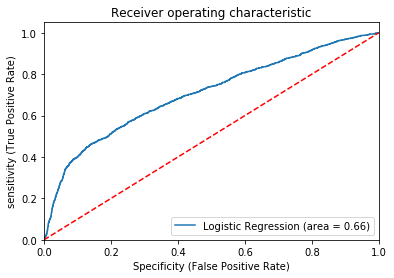

In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('sensitivity (True Positive Rate)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

A model with high discrimination ability will have high sensitivity (True Positive Rate) and specificity (False Positive Rate)  simultaneously, leading to an ROC curve which goes close to the top left corner of the plot. A model with no discrimination ability will have an ROC curve which is the 45 degree diagonal line.
In this case, we can see that this model is mot too good

### features with 3 way interactions